In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import UnitaryGate
from qiskit.circuit.library import QFT
from qiskit_aer import AerSimulator
import numpy as np
from math import gcd, floor, log
from fractions import Fraction
import random

In [2]:
def mod_mult_gate(b,N):
    if gcd(b,N)>1:
        print(f"Error: gcd({b},{N}) > 1")
    else:
        n = floor(log(N-1,2)) + 1
        U = np.full((2**n,2**n),0)
        for x in range(N): U[b*x % N][x] = 1
        for x in range(N,2**n): U[x][x] = 1
        G = UnitaryGate(U)
        G.name = f"M_{b}"
        return G

In [3]:
def order_finding_circuit(a,N):
    if gcd(a,N)>1:
        print(f"Error: gcd({a},{N}) > 1")
    else:
        n = floor(log(N-1,2)) + 1
        m = 2*n

        control = QuantumRegister(m, name = "X")
        target = QuantumRegister(n, name = "Y")
        output = ClassicalRegister(m, name = "Z")
        circuit = QuantumCircuit(control, target, output)


        circuit.x(m)
        
        for k, qubit in enumerate(control):
            circuit.h(k)
            b = pow(a,2**k,N)
            circuit.compose(
                mod_mult_gate(b,N).control(),
                qubits = [qubit] + list(target),
                inplace=True)

        # Apply the inverse QFT to the control register
        circuit.compose(
            QFT(m, inverse=True),
            qubits=control,
            inplace=True)

        # Measure the control register
        circuit.measure(control, output)

        return circuit

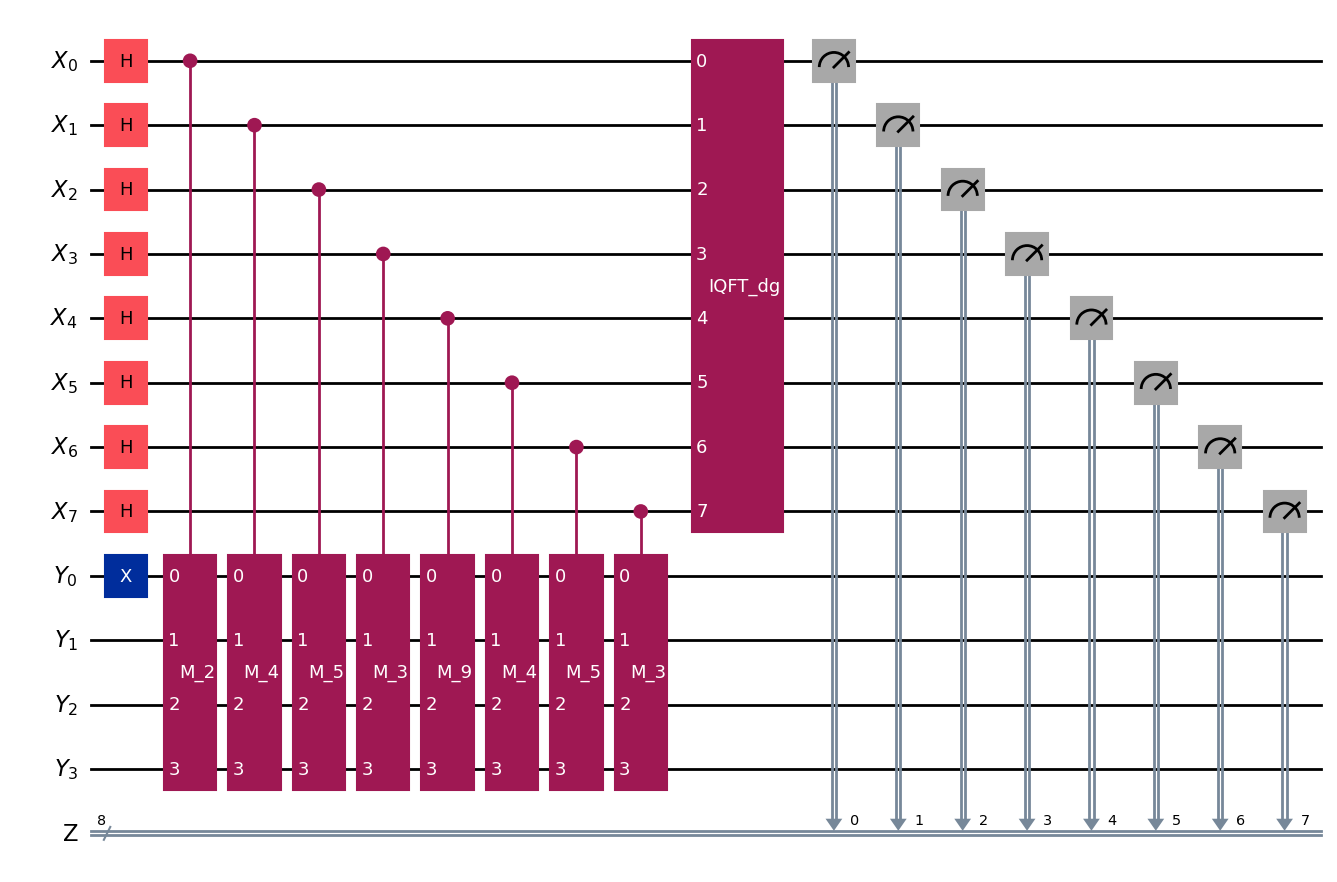

In [4]:
order_finding_circuit(2,11).draw(output = "mpl")

In [5]:
def find_order(a,N):
    if gcd(a,N)>1:
        print(f"Error: gcd({a},{N}) > 1")
    else:
        n = floor(log(N-1,2)) + 1
        m = 2*n
        circuit = order_finding_circuit(a,N)
        transpiled_circuit = transpile(circuit,AerSimulator())

        while True:
            result = AerSimulator().run(
                transpiled_circuit,
                shots=1,
                memory=True).result()
            y = int(result.get_memory()[0],2)
            r = Fraction(y/2**m).limit_denominator(N).denominator
            if pow(a,r,N)==1: break
        return r

In [6]:
N = 45

FACTOR_FOUND = False

if N % 2 == 0:
    print("Even number")
    d = 2
    FACTOR_FOUND = True
else:
    for k in range(2,round(log(N,2))+1):
        d = int(round(N ** (1/k)))
        if d**k == N:
            FACTOR_FOUND = True
            print("Number is a power")
            break

while not FACTOR_FOUND:
    a = random.randint(2,N-1)
    d = gcd(a,N)
    if d>1:
        FACTOR_FOUND = True
        print(f"Lucky guess of {a} modulo {N}")
    else:
        r = find_order(a,N)
        print(f"The order of {a} modulo {N} is {r}")
        if r % 2 == 0:
            x = pow(a,r//2,N) - 1
            d = gcd(x,N)
            if d>1: FACTOR_FOUND = True

print(f"Factor found: {d}")

The order of 14 modulo 45 is 6
The order of 16 modulo 45 is 3
The order of 22 modulo 45 is 12
Factor found: 9
